In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/TTNT/modular-code/lib/'

/content/drive/MyDrive/TTNT/modular-code/lib


In [3]:
# import the required libraries
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.metrics import r2_score, mean_squared_error

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
sns.set(font_scale=1.5)

In [6]:
# read the final csv data
data = pd.read_csv("../input/resd_features.csv")
data.shape

(196, 9)

In [7]:
data.describe()

,surface,n_bhk,sa1,pool,sa9,sa7,sa2,sa5,price
count,1.960000e+02,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000
mean,6.797284e-17,2.385204,0.061224,0.632653,0.040816,0.081633,0.051020,0.056122,8.698673
std,1.002561e+00,0.847824,0.240356,0.483317,0.198371,0.274505,0.220603,0.230747,5.807492
min,-2.080191e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.319000
25%,-5.953332e-01,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.100000
50%,-2.634395e-01,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,7.000000
75%,3.943500e-01,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,9.746750
max,4.141817e+00,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,46.000000


In [ ]:
# sa1: baner, sa9: nibm, sa7: kharadi, sa2: bavdhan, sa5: handewadi

## Data prepration

In [8]:
data = data.sort_values("surface").reset_index(drop=True)

In [9]:
# Selecting the feature matrix and target vector
X = data.iloc[:, :-1]
y = data["price"]


In [11]:
from scipy import stats
from sklearn.preprocessing import StandardScaler

In [12]:
# Xử lý outliers
z_scores = stats.zscore(X)
X_no_outliers = X[(np.abs(z_scores) < 3).all(axis=1)]
y_no_outliers = y[X.index.isin(X_no_outliers.index)]

print(f"Số lượng mẫu trước khi loại bỏ outliers: {len(X)}")
print(f"Số lượng mẫu sau khi loại bỏ outliers: {len(X_no_outliers)}")

Số lượng mẫu trước khi loại bỏ outliers: 196
Số lượng mẫu sau khi loại bỏ outliers: 132


In [13]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_no_outliers)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_no_outliers.columns)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y_no_outliers, test_size=0.2, random_state=42)

In [10]:
# Random sate for data splitting
rs = 118
# X_train, X_test, y_train, y_test = \
#     train_test_split(X, y, test_size=.3, random_state=rs)

In [15]:
# function for performing grid search
def gridSearchReport( estimator, X, y, pg, cv=LeaveOneOut(), rs=118 ):
    """
    Performs the grid search and cross validation for the given regressor.
    Params:
        estimator:  the regressor
        X: Pandas dataframe, feature data
        y: Pandas series, target
        pg: dict, parameters' grid
        cv: int, cross-validation generator or an iterable, cross validation folds
        rs: int, training-test split random state
    """

    t0 = time()

    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=rs) # train tets split

    est_cv = GridSearchCV(
        estimator,
        param_grid=pg,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        cv=cv
       )

    est_cv.fit(X_train, y_train)

    print("Best parameters:", est_cv.best_params_) # best parameters
    print("Best CV score:", abs(est_cv.best_score_)) # cross validation score
    y_train_pred, y_test_pred = est_cv.predict(X_train), est_cv.predict(X_test) # predictions on train and test data
    print("MSE, R2 train:", mean_squared_error(y_train, y_train_pred),  # evaluation metrics
          ", ", r2_score(y_train, y_train_pred) )
    print("MSE, R2 test:", mean_squared_error(y_test, y_test_pred),
          ", ", r2_score(y_test, y_test_pred) )

    t = round(time()-t0, 2)
    print("Elapsed time:", t, "s ,", round(t/60, 2), "min")

    return est_cv




In [16]:
# function to plot the residuals
def plotResidue(estimator, X, y, rs=118):
    """
    Plots the fit residuals (price - predicted_price) vs. "surface" variable.
    Params:
        estimator: GridSearchCV, the regressor
        X: Pandas dataframe, feature data
        y: Pandas series, target
        rs: int, random state
    """
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=rs) # train tets split

    residue_train = y_train-estimator.predict(X_train) # make predictions
    residue_test = y_test-estimator.predict(X_test)

    fig, axe = plt.subplots(1, 2, figsize=(18,10))
    axe[0].scatter( X_train["surface"], residue_train, label="train" )
    axe[0].scatter( X_test["surface"], residue_test, label="test" )
    axe[0].plot( [-2.3, 4.5], [0,0], "black" )
    axe[0].set_xlabel("Scaled surface")
    axe[0].set_ylabel("Fit residulas")
    axe[0].legend()

    axe[1].hist(residue_test, bins=25)
    axe[1].set_xlabel("Fit residual for test set")
    axe[1].set_ylabel("Count")


    plt.show()

    print("mean residuals:", round(np.mean(residue_test), 2),
          "\nstd:", round(np.std(residue_test), 2))


## Ordinary Linear Regression

In [17]:
# define a simple linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [19]:
# Hàm xử lý giá dự đoán âm
def non_negative_predict(model, X):
    return np.maximum(0, model.predict(X))

In [21]:
# check for the r2 score on train and tets data
r2_score(y_train, lr.predict(X_train)),\
r2_score(y_test, lr.predict(X_test))

(0.6421148233944602, 0.5904938542261526)

In [49]:
sample_data = scaler.transform(X.iloc[[7]])  # Chuyển đổi để giữ định dạng 2 chiều
predicted_price = non_negative_predict(lr, sample_data)

# In giá trị dự đoán
print(f"Dự đoán giá cho dòng dữ liệu này: {predicted_price[0]}")
print(f"Giá của dòng dữ liệu này: {y[7]}")

Dự đoán giá cho dòng dữ liệu này: 3.7566220956549508
Giá của dòng dữ liệu này: 3.999000000000001


In [50]:
X.iloc[[7]]


,surface,n_bhk,sa1,pool,sa9,sa7,sa2,sa5
7,-1.293776,2.0,0,0,0,1,0,0


In [51]:
y[7]

3.999000000000001

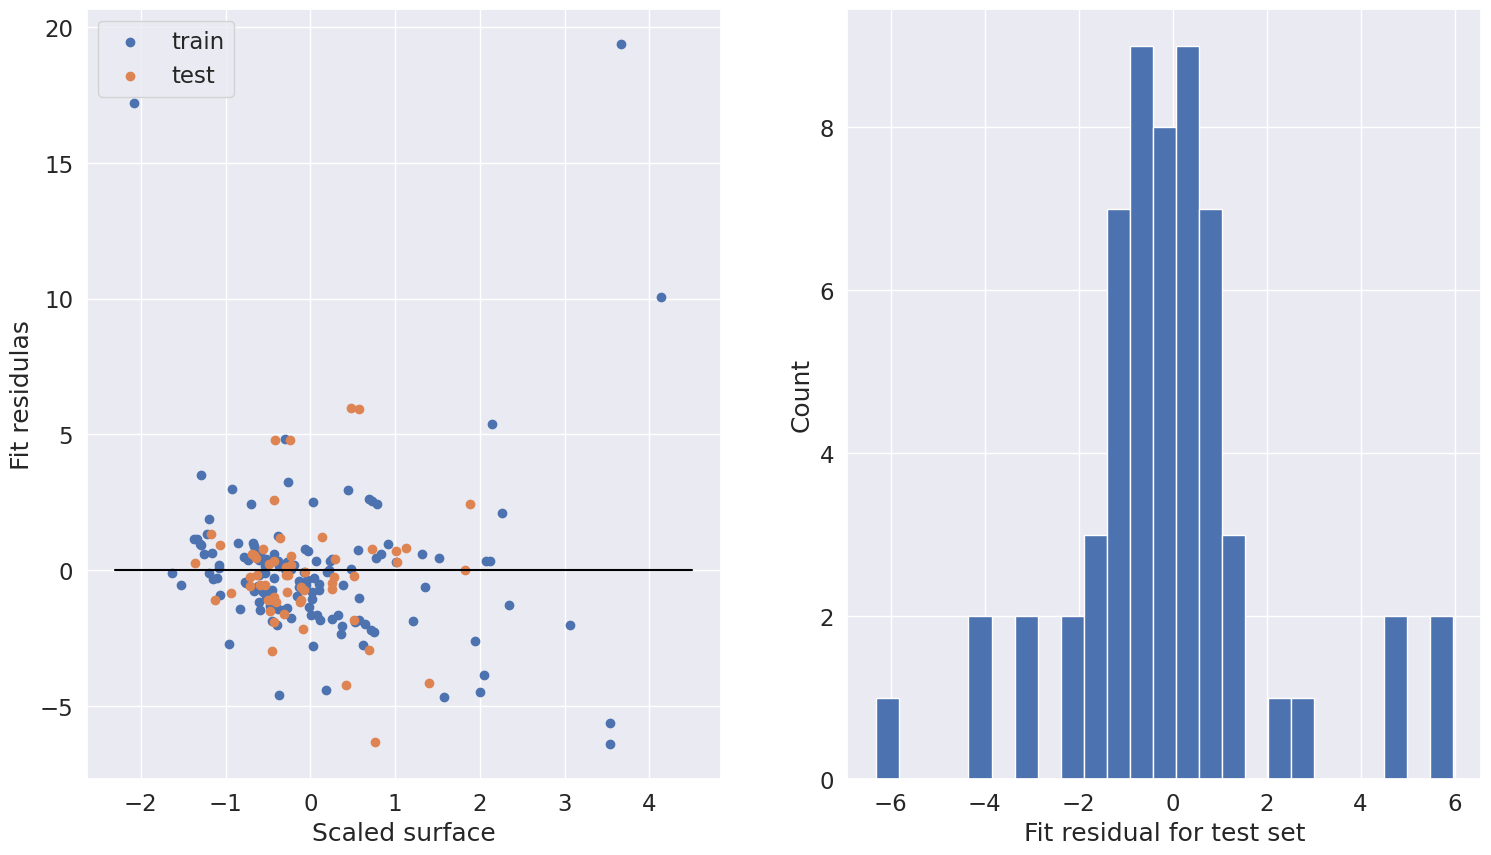

mean residuals: -0.1 
std: 2.1


In [ ]:
# plot the residuals
plotResidue(lr, X, y, rs=rs)

## Ridge Regression

In [ ]:
# define the parameters for ridge regression model and check for the grid search
alphas = np.logspace(-3,3,100)
pg = {"alpha":alphas}
ridge = Ridge()
ridg_cv = gridSearchReport( ridge, X, y, pg, rs=rs )

Best parameters: {'alpha': 10.0}
Best CV score: 11.800965273439633
MSE, R2 train: 9.43130688285795 ,  0.7665017863457696
MSE, R2 test: 4.5414169006178735 ,  0.734775355046485
Elapsed time: 66.33 s , 1.11 min


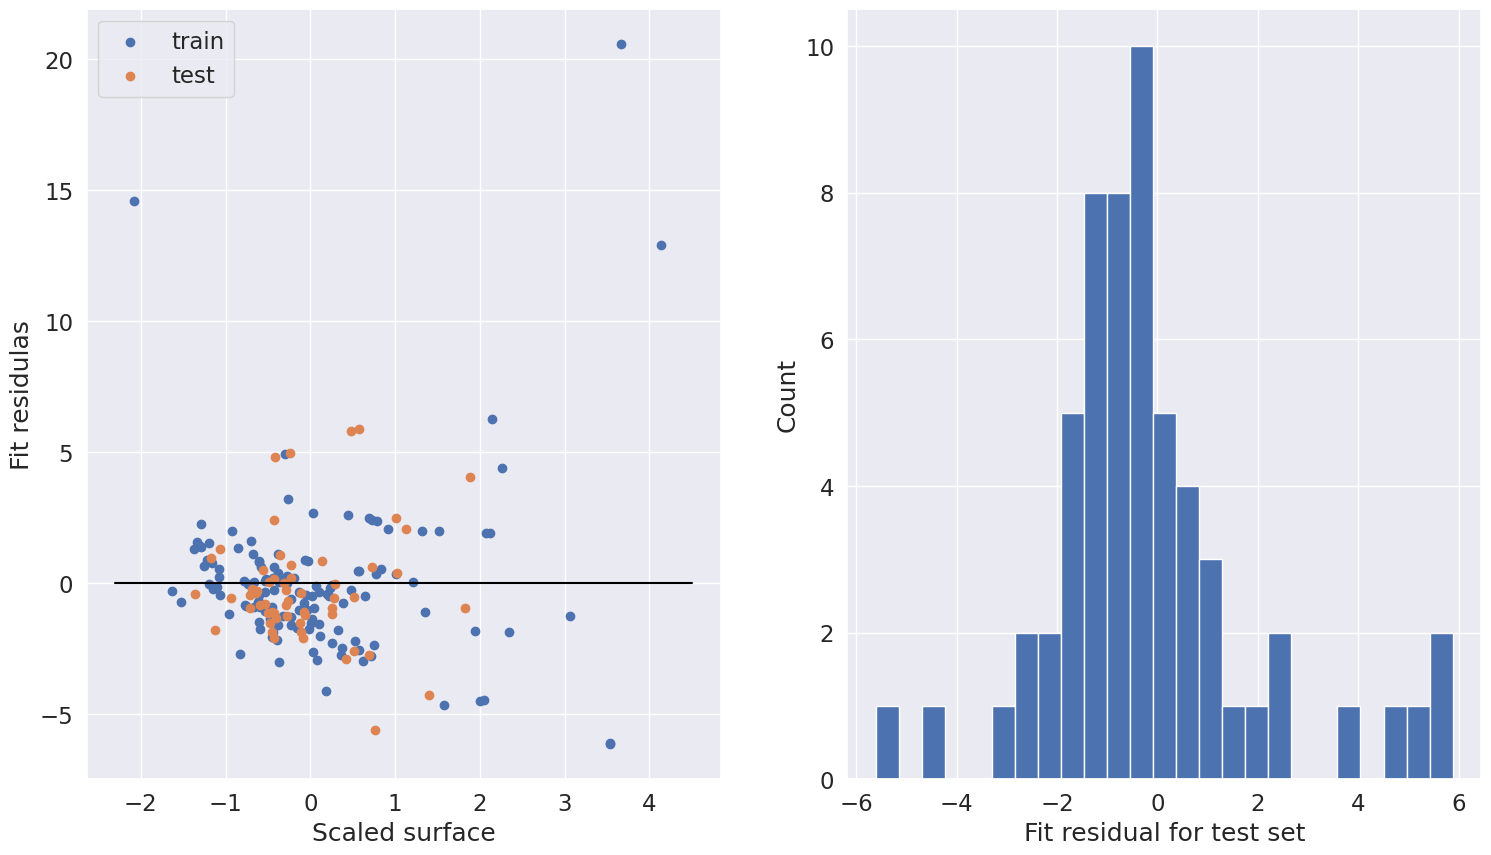

mean residuals: -0.19 
std: 2.12


In [ ]:
# plot the residuals
plotResidue(ridg_cv, X, y, rs)

## Lasso Regression

In [ ]:
# define the parameters and plot the lasso regression model
lasso = Lasso()
pg = {"alpha":alphas}
lasso_cv = gridSearchReport( lasso, X, y, pg, rs=rs )

Best parameters: {'alpha': 0.3511191734215131}
Best CV score: 11.639635858092895
MSE, R2 train: 10.336902819264557 ,  0.7440812420808165
MSE, R2 test: 5.367273968426112 ,  0.6865442297423997
Elapsed time: 64.67 s , 1.08 min


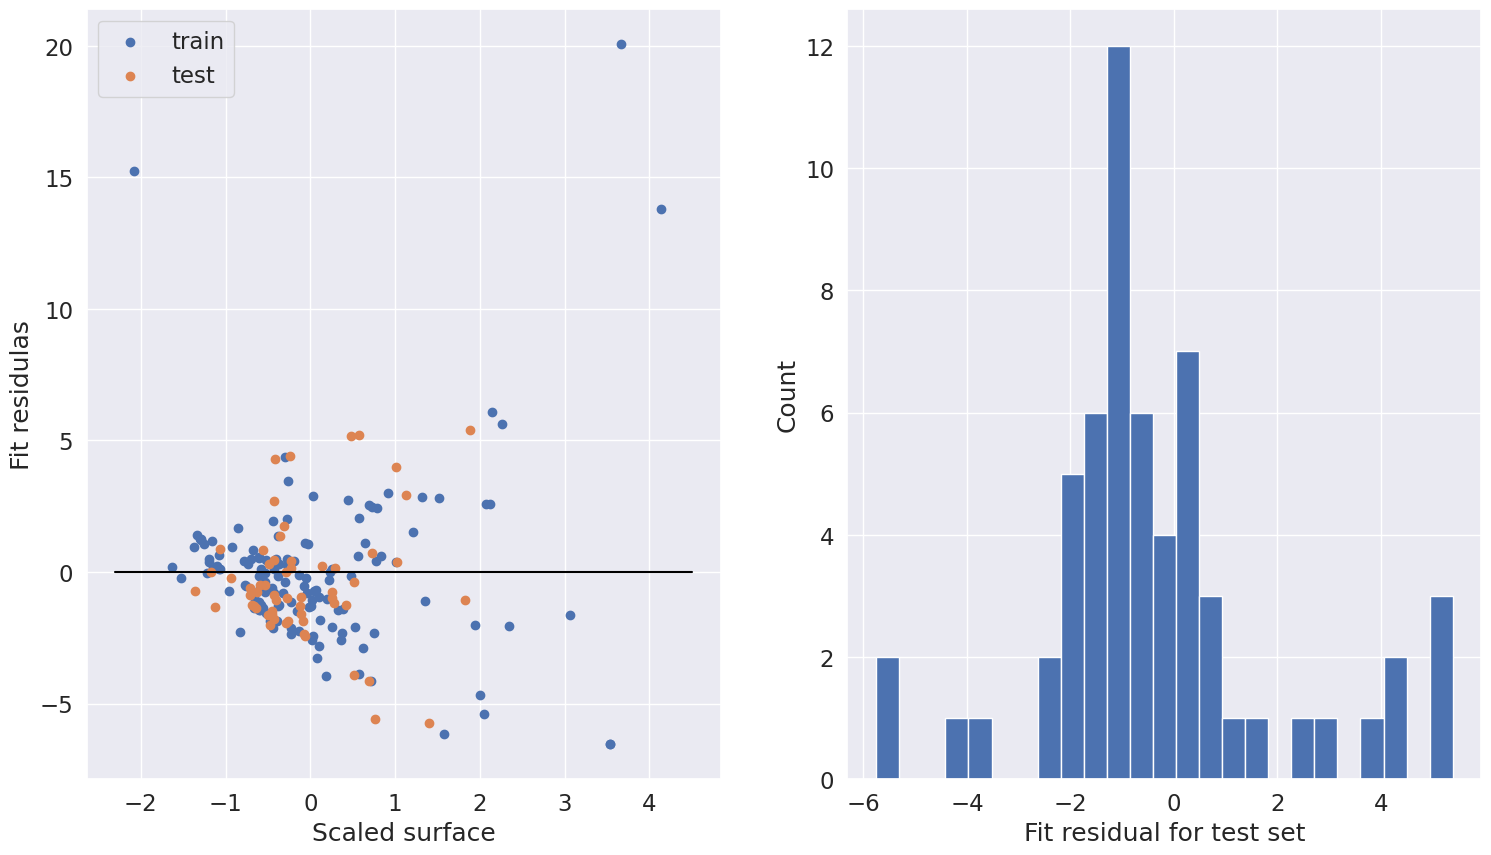

mean residuals: -0.31 
std: 2.3


In [ ]:
# plot the residuals
plotResidue(lasso_cv, X, y, rs=rs)

## Lasso and Ridge Combination

In [ ]:
# define an elasticnet model
l1_ratio = np.random.rand(20)
elastic = ElasticNet()
pg = {"alpha":np.linspace(0.1,1,5), "l1_ratio":l1_ratio}
elastic_cv = gridSearchReport( elastic, X, y, pg, rs=rs )

Best parameters: {'alpha': 0.325, 'l1_ratio': 0.8927406579537608}
Best CV score: 11.704474830573714
MSE, R2 train: 10.402102126082593 ,  0.7424670520366801
MSE, R2 test: 5.402077751703233 ,  0.6845116435991945
Elapsed time: 66.23 s , 1.1 min


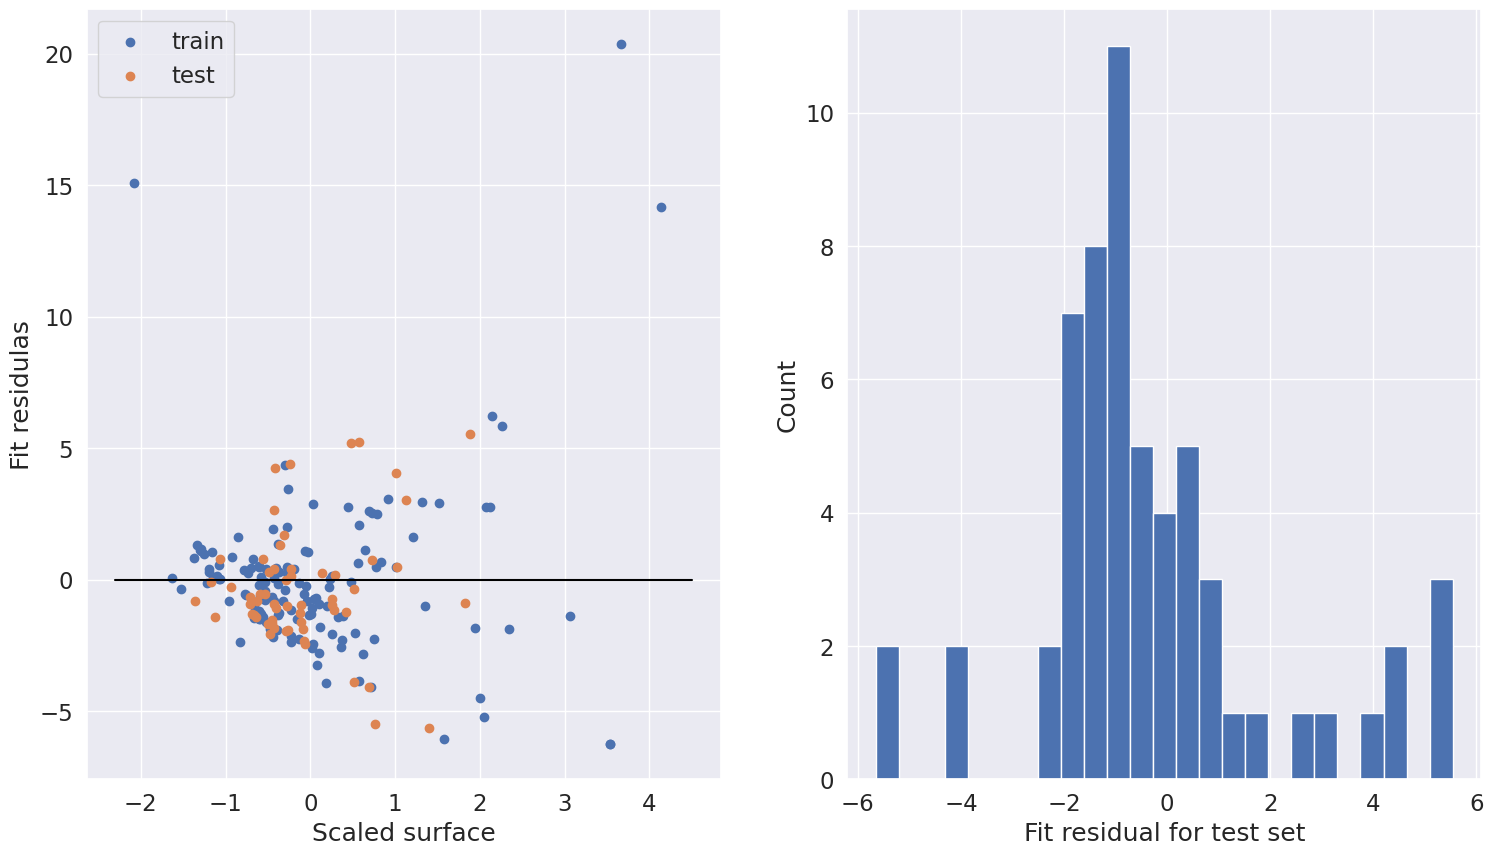

mean residuals: -0.32 
std: 2.3


In [ ]:
# plot the residuals
plotResidue(elastic_cv, X, y, rs=rs)

## Random Forest Regressor

In [ ]:
# define a random forest regression model
rfr = RandomForestRegressor( random_state=10 )
pg = {"n_estimators":[10, 20, 30, 50],
         "criterion":["squared_error", "absolute_error", "poisson"],
         "max_depth":[2,3,4],
         "min_samples_split":range(2, 10),
         "min_samples_leaf":[2,3],
         "max_features":range(4, X_train.shape[1]+1)
        }
rfr_cv = gridSearchReport( rfr, X, y, pg, cv=5, rs=rs )

Best parameters: {'criterion': 'poisson', 'max_depth': 4, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
Best CV score: 9.534618847932967
MSE, R2 train: 4.8584989409685075 ,  0.8797143558313154
MSE, R2 test: 5.647659109141971 ,  0.6701693733872196
Elapsed time: 644.8 s , 10.75 min


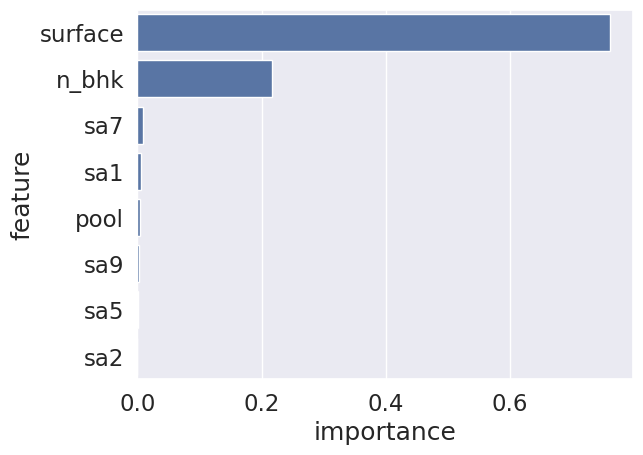

In [ ]:
# find the best features
rfr = rfr_cv.best_estimator_
df_imp = pd.DataFrame(zip(rfr.feature_names_in_, rfr.feature_importances_))
df_imp.columns = ["feature", "importance"]
df_imp = df_imp.sort_values("importance", ascending=False).reset_index(drop=True)

sns.barplot( data=df_imp, x="importance", y="feature"  )
plt.show()

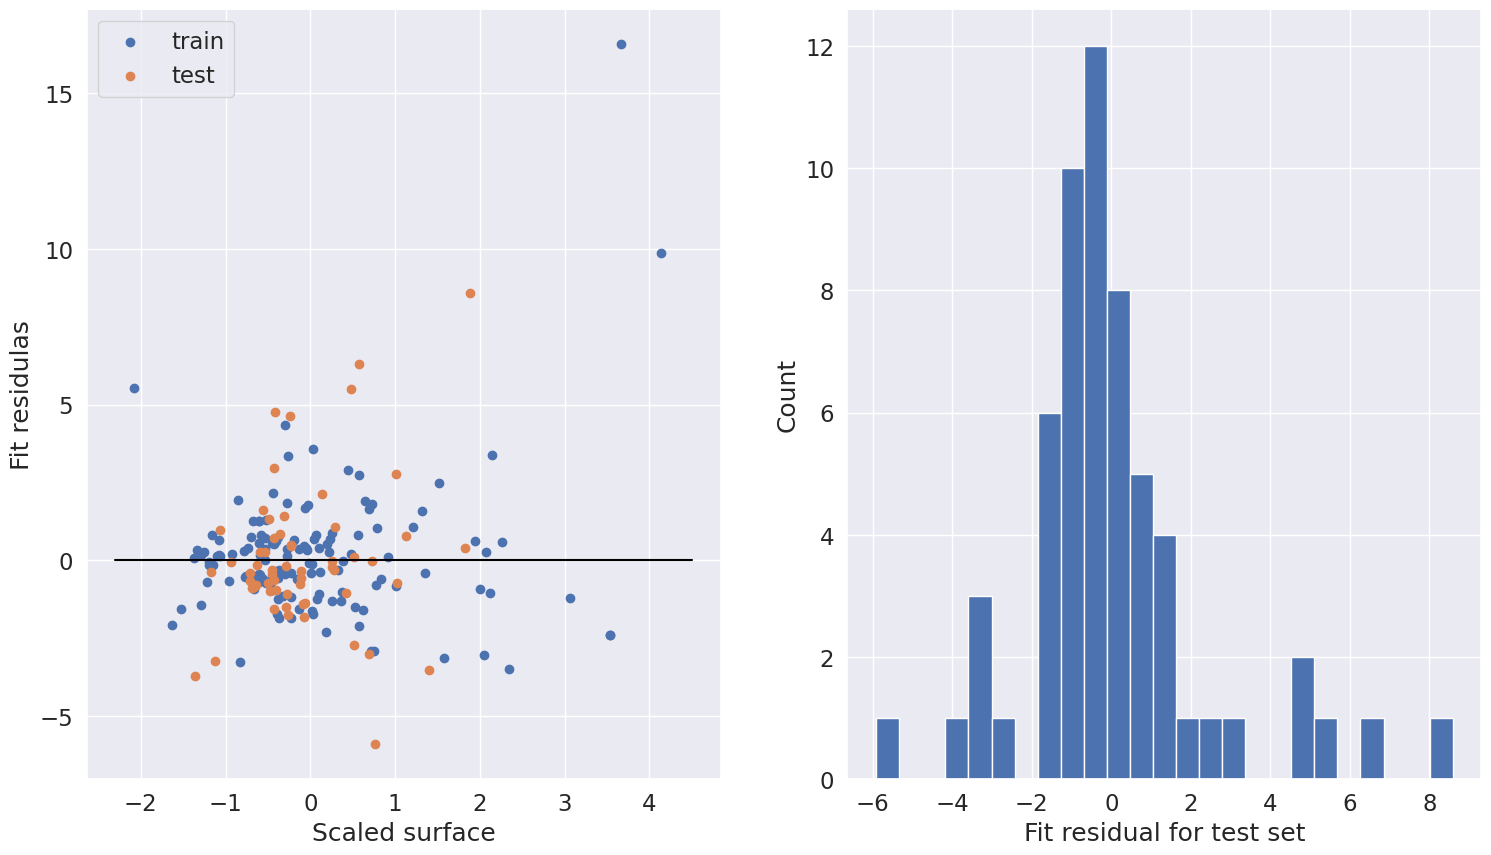

mean residuals: 0.05 
std: 2.38


In [ ]:
# plot the residuals
plotResidue(rfr_cv, X, y, rs=rs)

## XGboost (extreme gradient boosting)

In [ ]:
# define the parameters for XGBoost model
from scipy.stats import uniform
param_grid = {'max_depth':range(2,7),
      'gamma':uniform(loc=0.0, scale=3), # minimum of the loss function rduction to split a node
      'min_child_weight':range(3,6), # similar to min_samples_leaf
      'colsample_bytree':uniform(loc=0.1, scale=0.9), # similar to the max_features
      'subsample':uniform(loc=0.5, scale=0.5), # similar to bootstraping in RF
      'learning_rate':uniform(loc=0.01, scale=0.99)} # contriburion rate of each estimator

In [ ]:
from sklearn.model_selection import ParameterSampler
rng = np.random.RandomState(20)
n_iter=500
param_list = list(ParameterSampler(param_grid, n_iter=n_iter,
                                   random_state=rng))

In [ ]:
param_list[0]

{'colsample_bytree': 0.6293177209695467,
 'gamma': 2.6931411837282537,
 'learning_rate': 0.8926154221799609,
 'max_depth': 3,
 'min_child_weight': 3,
 'subsample': 0.5179447928084266}

In [ ]:
# function to perform cross validation
from sklearn.model_selection import KFold

def cross_validate( est, Xn, yn, n_fold=10 ):
    """
    Cross validation for XGB fit.
    Params:
        est: xgb regressor
        Xn: numpy array (n_sample, n_feature)
            Training feature matrix
        yn: numpy array (n_sample,)
            Training target vector
        n_fold: int
            number of folds for cross validating
    """
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    mean_train_error, mean_val_error = 0., 0.
    for train_index, val_index in kf.split(Xn, yn):
        est.fit(Xn[train_index], yn[train_index],
                    eval_set=[(Xn[train_index], yn[train_index]),
                              (Xn[val_index], yn[val_index])],
                    verbose=False)
#                    eval_metric='rmse',
#                    early_stopping_rounds=30)   #Xóa eval_metric và early_stopping_rounds
        mean_val_error += mean_squared_error(yn[val_index], est.predict(Xn[val_index]))
        mean_train_error += mean_squared_error(yn[train_index], est.predict(Xn[train_index]))

    return mean_train_error/n_fold, mean_val_error/n_fold

In [ ]:
%%time
# XGBoost model
xgbr = xgb.XGBRegressor( objective='reg:squarederror', n_estimators=1000, verbosity=1,
                         eval_metric='rmse', early_stopping_rounds=30) #Thêm lại eval_metric và early_stopping_rounds vào

val_score, train_score = [], []
counter = 0
for param_grid in param_list:
    xgbr.set_params(**param_grid)
    train_error, val_error = cross_validate(xgbr, X_train.values, y_train.values)
    val_score.append(val_error)
    train_score.append(train_error)

    if counter%50 == 0 :
        print("iter =", counter,
              "train_score=", train_score[counter], ", ",
              "val_score=", val_score[counter])
    counter += 1


iter = 0 train_score= 6.0371103839592415 ,  val_score= 9.355311059662013
iter = 50 train_score= 7.177504444790422 ,  val_score= 9.177823073113233
iter = 100 train_score= 8.054390696704306 ,  val_score= 10.290483357042612
iter = 150 train_score= 7.101563925103046 ,  val_score= 11.23521882069696
iter = 200 train_score= 8.637692301565972 ,  val_score= 10.852486361685123
iter = 250 train_score= 6.324964862150879 ,  val_score= 8.90139833417033
iter = 300 train_score= 7.560529500847939 ,  val_score= 10.850444362281198
iter = 350 train_score= 8.014543532325712 ,  val_score= 10.957607210240702
iter = 400 train_score= 9.119186842058683 ,  val_score= 11.237861866702199
iter = 450 train_score= 9.411184109509488 ,  val_score= 11.358033558691632
CPU times: user 7min 18s, sys: 9.47 s, total: 7min 28s
Wall time: 4min 34s


In [ ]:
df_grid = pd.DataFrame(param_list)
df_grid["train_score"] = train_score
df_grid["val_score"] = val_score
df_grid

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample,train_score,val_score
0,0.629318,2.693141,0.892615,3,3,0.517945,6.037110,9.355311
1,0.722582,1.136043,0.523326,4,5,0.596925,9.797195,10.430000
2,0.345085,2.155818,0.785174,3,4,0.887622,6.891529,14.106208
3,0.132998,0.350081,0.753768,4,4,0.627403,12.253292,12.936720
4,0.871863,2.849337,0.566070,2,5,0.726722,8.471377,9.722246
...,...,...,...,...,...,...,...,...
495,0.287347,1.044718,0.207315,5,4,0.521568,9.389320,11.369645
496,0.211245,2.442034,0.178679,4,3,0.501152,9.854540,11.675038
497,0.772129,2.011557,0.063765,5,3,0.881116,5.316639,9.707500
498,0.206156,1.858437,0.288957,2,3,0.929107,7.177873,10.094921


In [ ]:
df_grid_best = df_grid[ df_grid["val_score"]==min(val_score) ]
df_grid_best

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample,train_score,val_score
124,0.985226,0.193439,0.965628,3,3,0.672562,5.683894,6.803792


In [ ]:
# best parameters
best_params = df_grid_best.iloc[0, :-2].to_dict()
best_params

{'colsample_bytree': 0.9852260850749124,
 'gamma': 0.19343879705385558,
 'learning_rate': 0.9656281641834209,
 'max_depth': 3.0,
 'min_child_weight': 3.0,
 'subsample': 0.6725618279096337}

In [ ]:
best_params["max_depth"] = int(best_params["max_depth"])

In [ ]:
# Xóa eval_metric khỏi fit() và thêm vào khởi tạo XGBRegressor
xgbr.set_params(**best_params, eval_metric='rmse', early_stopping_rounds=30)
xgbr.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
#                eval_metric='rmse',
                verbose=True)
#                early_stopping_rounds=30)


[0]	validation_0-rmse:3.28182	validation_1-rmse:2.75263
[1]	validation_0-rmse:3.05097	validation_1-rmse:2.65515
[2]	validation_0-rmse:2.52203	validation_1-rmse:2.66274
[3]	validation_0-rmse:2.32847	validation_1-rmse:2.64994
[4]	validation_0-rmse:2.18560	validation_1-rmse:2.51814
[5]	validation_0-rmse:2.15871	validation_1-rmse:2.43332
[6]	validation_0-rmse:2.13179	validation_1-rmse:2.28154
[7]	validation_0-rmse:2.12070	validation_1-rmse:2.38521
[8]	validation_0-rmse:2.03633	validation_1-rmse:2.16055
[9]	validation_0-rmse:2.00794	validation_1-rmse:2.50015
[10]	validation_0-rmse:2.00570	validation_1-rmse:2.52943
[11]	validation_0-rmse:1.95969	validation_1-rmse:2.54994
[12]	validation_0-rmse:1.85340	validation_1-rmse:2.49372
[13]	validation_0-rmse:1.84306	validation_1-rmse:2.35923
[14]	validation_0-rmse:1.76060	validation_1-rmse:2.36743
[15]	validation_0-rmse:1.72007	validation_1-rmse:2.47842
[16]	validation_0-rmse:1.73968	validation_1-rmse:2.34627
[17]	validation_0-rmse:1.63212	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9852260850749124, device=None,
             early_stopping_rounds=30, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=0.19343879705385558,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.9656281641834209,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3.0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgbr.get_booster().attributes()

{'best_iteration': '28', 'best_score': '2.030968715311318'}

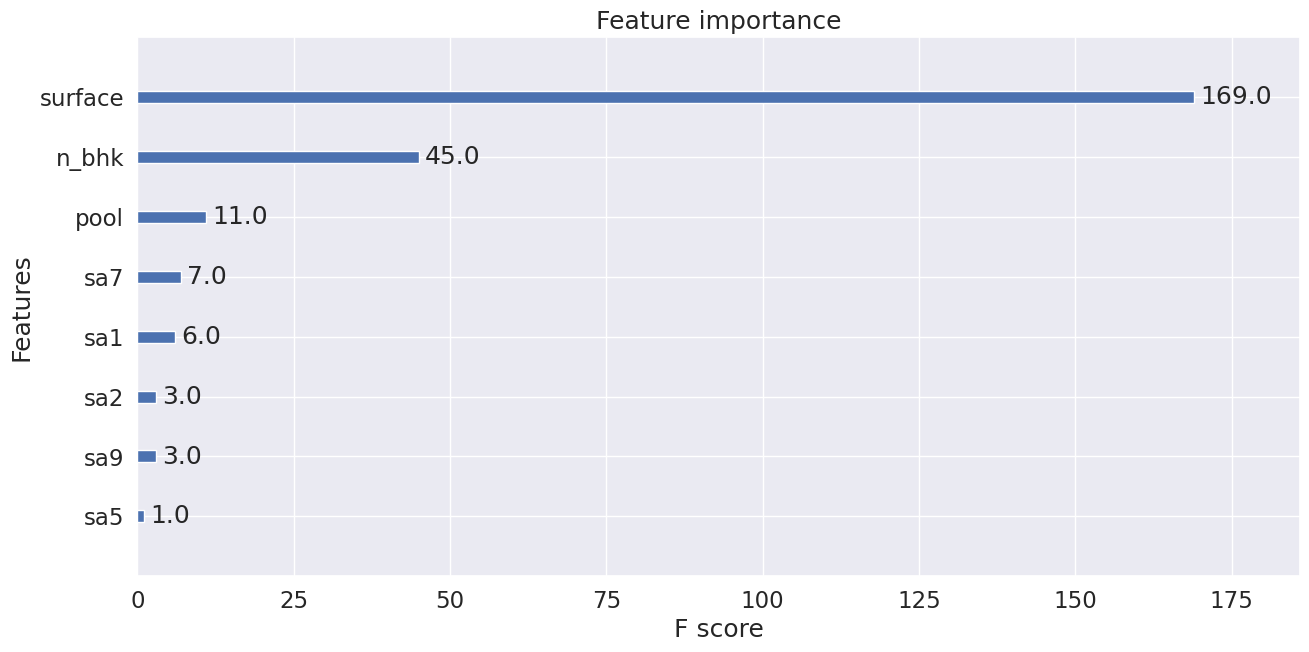

In [ ]:
# plot the feature importance
plt.rcParams["figure.figsize"] = (15,7)
xgb.plot_importance(xgbr)
plt.show()

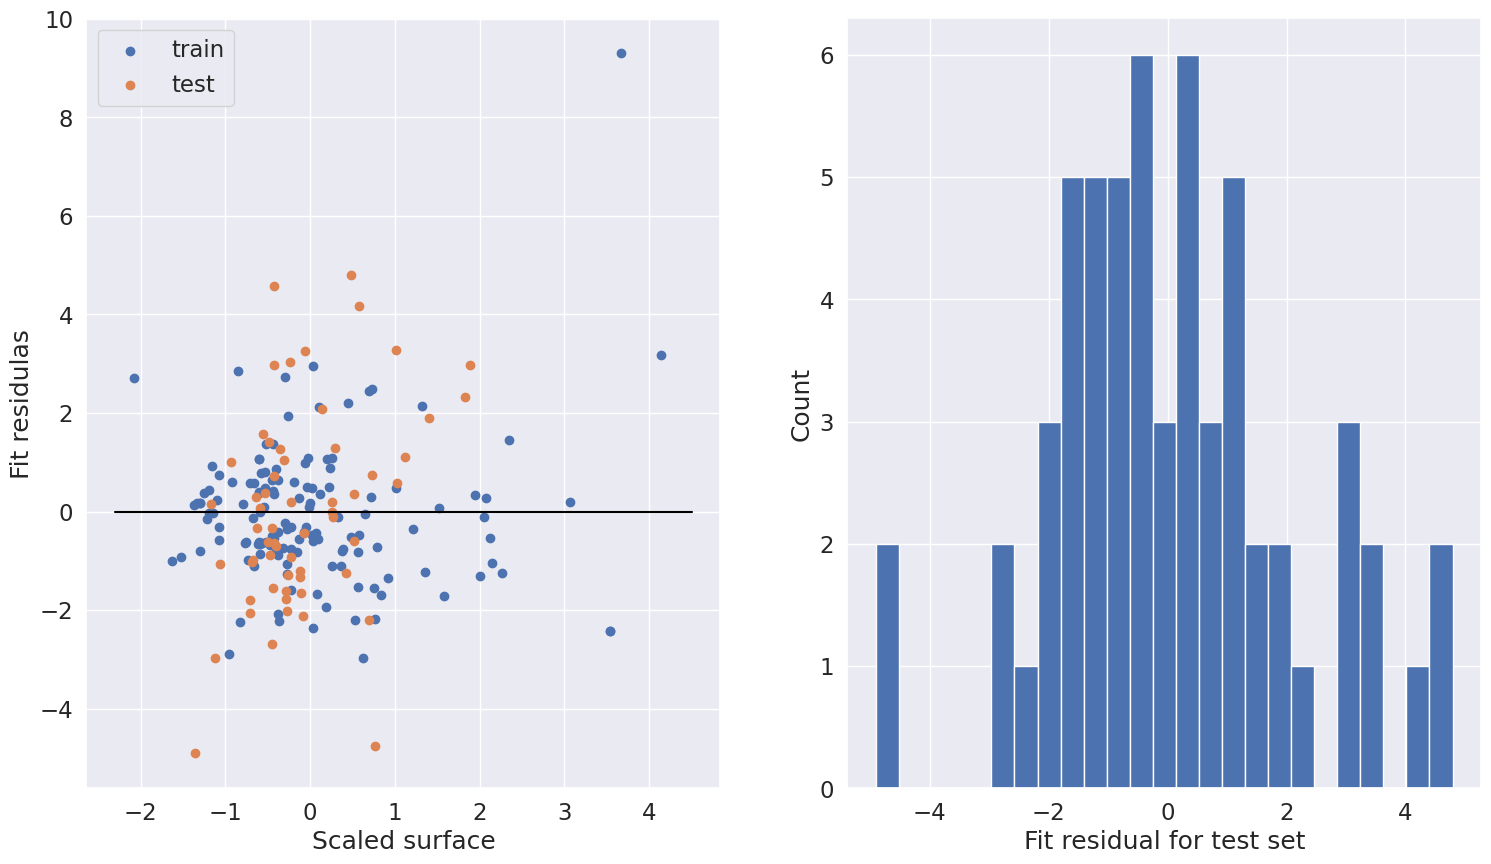

mean residuals: 0.03 
std: 2.03


In [ ]:
#  plot the residuals
plotResidue(xgbr, X, y, rs=rs)

## K-Nearest Neighbours Regression

In [ ]:
%%time
knn = KNeighborsRegressor() # KNN model
pg = {
    "n_neighbors": range(1,16),
    "weights": ['uniform', 'distance'],
    "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
}
knn_cv = gridSearchReport( knn, X, y, pg, rs=rs )

Best parameters: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'}
Best CV score: 9.079655860502838
MSE, R2 train: 5.413305728304945 ,  0.8659785718752488
MSE, R2 test: 4.7715140715630895 ,  0.7213373814351105
Elapsed time: 83.64 s , 1.39 min
CPU times: user 7.94 s, sys: 316 ms, total: 8.25 s
Wall time: 1min 23s


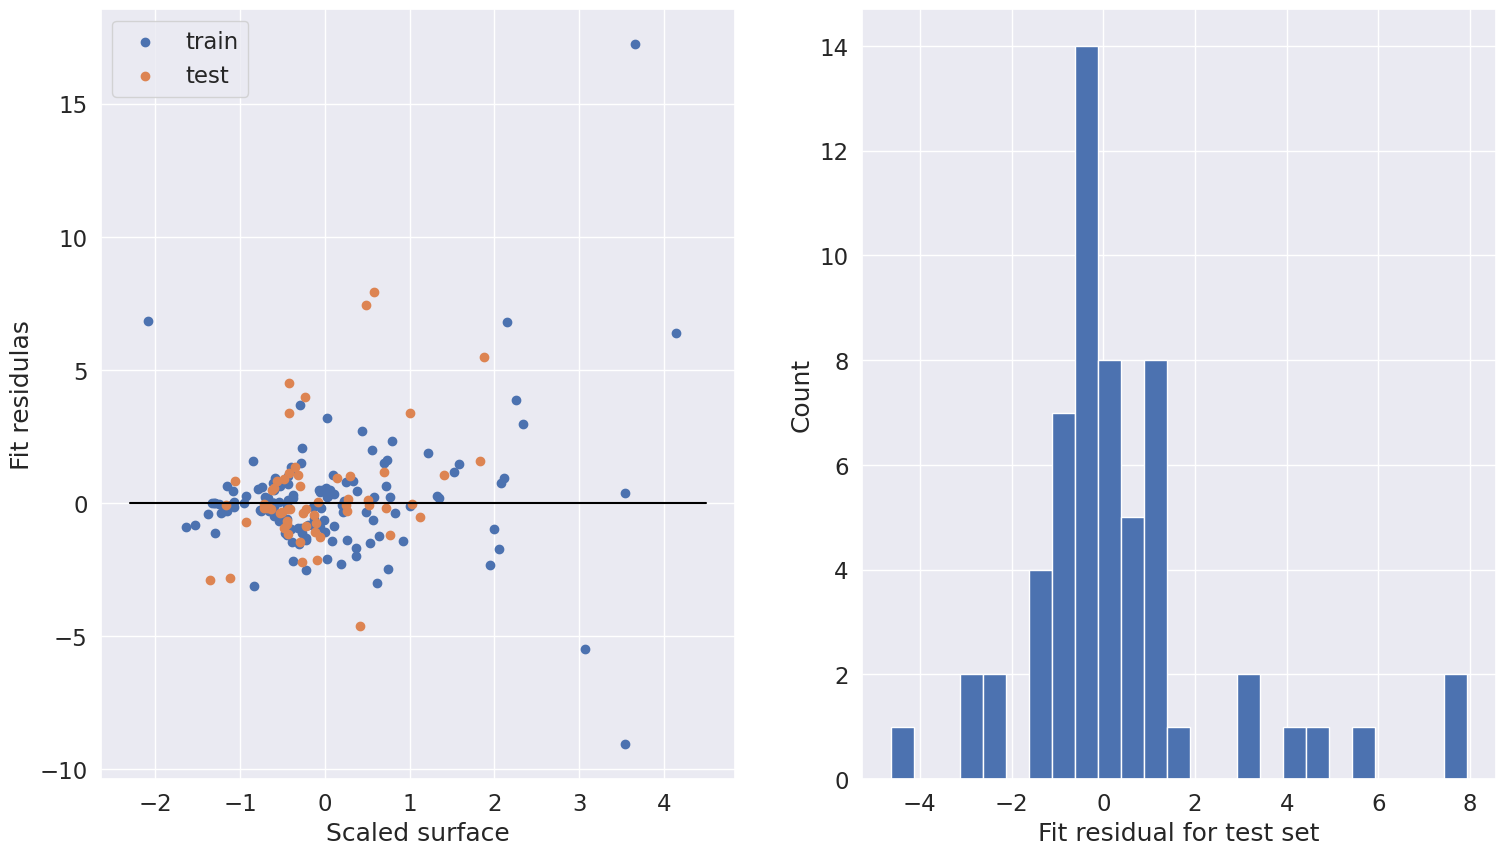

mean residuals: 0.34 
std: 2.16


In [ ]:
# plot the residuals
plotResidue(knn_cv, X, y, rs=rs)

In [ ]:
from sklearn.model_selection import validation_curve
param_range = range(1,31)
knn_cv = KNeighborsRegressor()
train_scores, val_scores = validation_curve(knn_cv,
                                             X_train, y_train,
                                             param_name="n_neighbors",
                                             param_range=param_range,
                                             n_jobs=-1,
                                             scoring="neg_mean_squared_error",
                                             cv=10
                                            )

In [ ]:
train_scores.shape

(30, 10)

In [ ]:
train_mean_score = -np.mean(train_scores, axis=1)
val_mean_score = -np.mean(val_scores, axis=1)

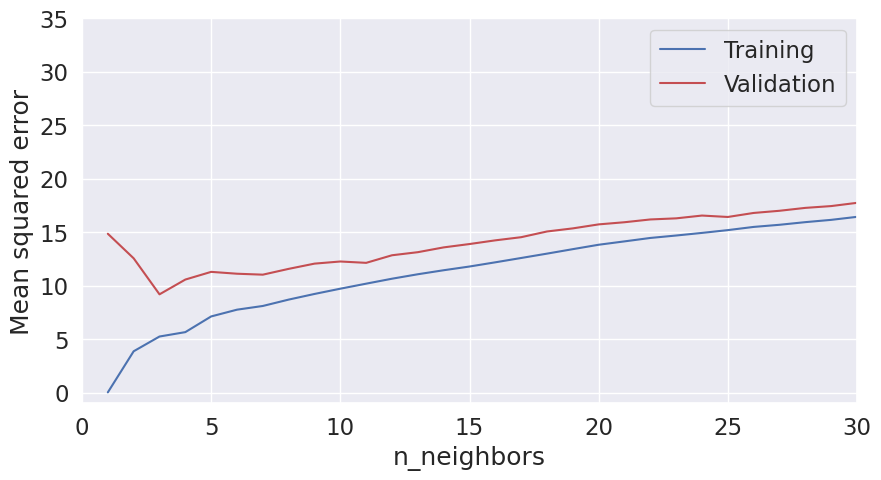

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot( param_range, train_mean_score, color="b", label="Training" )
plt.plot( param_range, val_mean_score, color="r", label="Validation" )
plt.xlim(1,15)
plt.xlabel( "n_neighbors" )
plt.ylim(-1, 35)
plt.xlim(0, 30)
plt.ylabel( "Mean squared error" )
plt.legend()
plt.show()

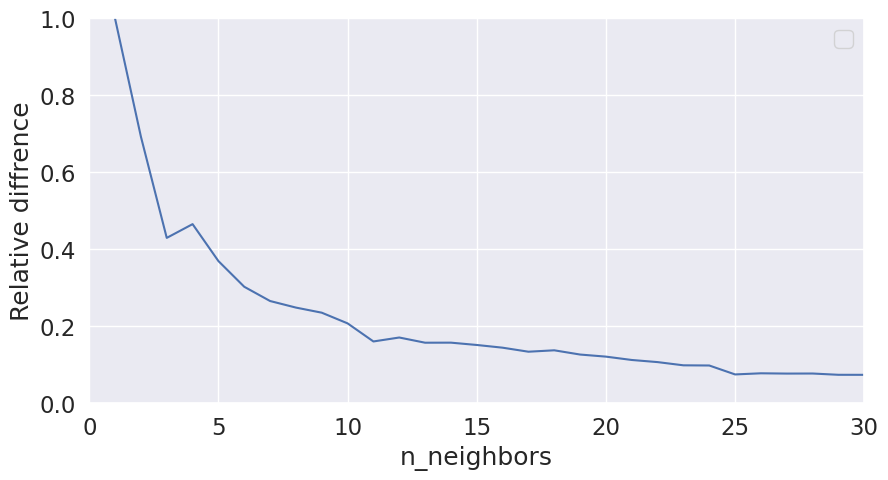

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot( param_range, (val_mean_score-train_mean_score)/val_mean_score )
plt.xlim(1,15)
plt.xlabel( "n_neighbors" )
plt.ylim(0, 1)
plt.xlim(0, 30)
plt.ylabel( "Relative diffrence" )
plt.legend()
plt.show()

In [ ]:
knn_cv = KNeighborsRegressor(n_neighbors=20, weights="uniform")
knn_cv.fit( X_train, y_train )
y_pred_knn = knn_cv.predict(X_test)
print(r2_score(y_train, knn_cv.predict(X_train)) , r2_score(y_test, y_pred_knn))
mean_squared_error(y_train, knn_cv.predict(X_train)) , mean_squared_error(y_test, y_pred_knn)

0.6747125836606344 0.6583595532846417


(13.138796227244525, 5.849877559152541)

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_list = cross_val_score(knn_cv, X_train, y_train,
                                 scoring="neg_mean_squared_error", cv=10)
score_val_knn = -np.mean(cross_val_list)
score_val_knn

15.72520725778709

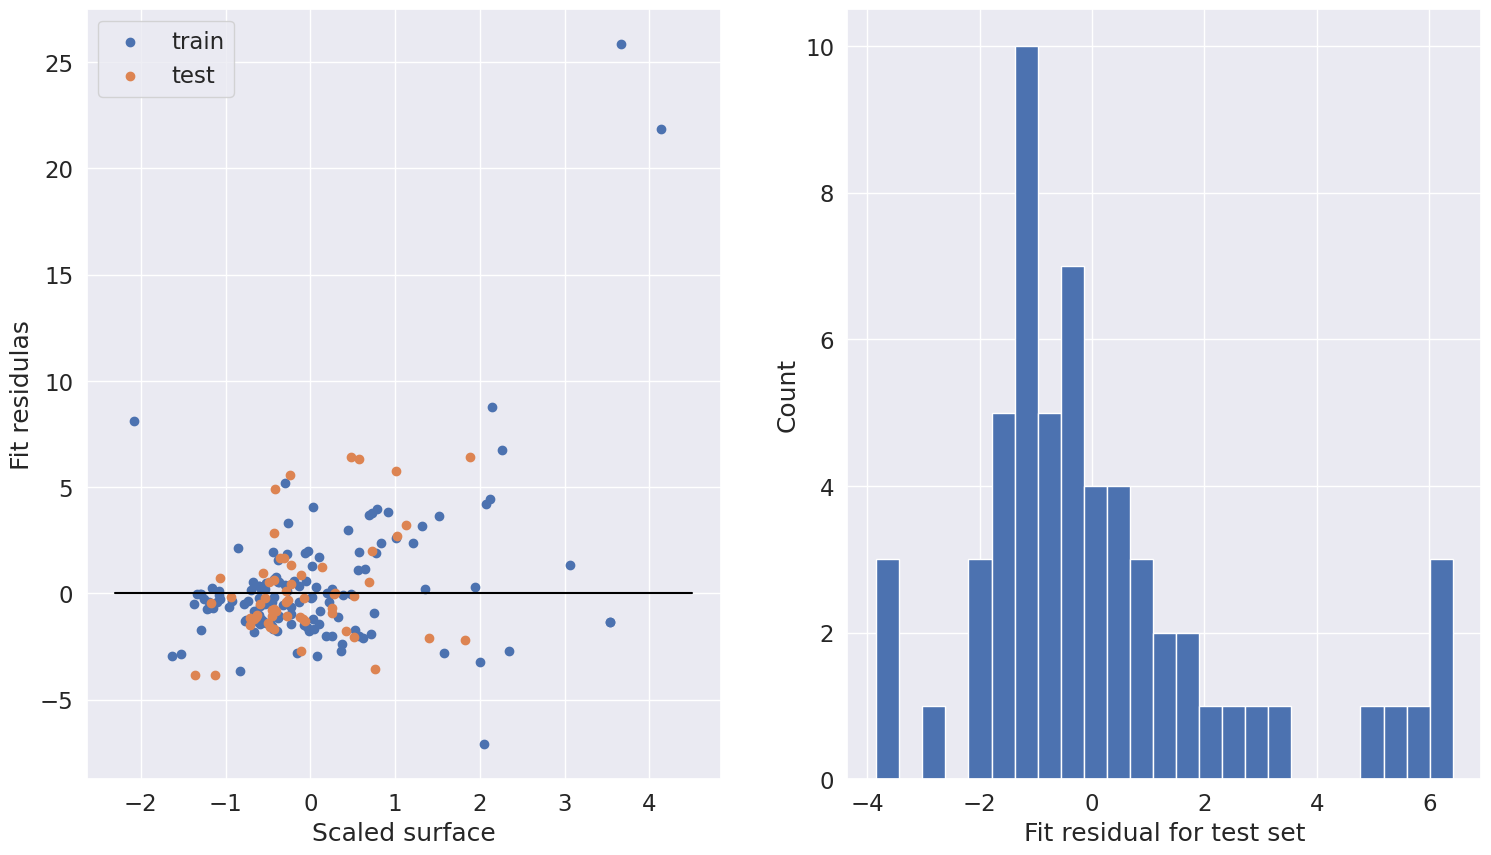

mean residuals: 0.18 
std: 2.41


In [ ]:
# plot the residuals
plotResidue(knn_cv, X, y, rs=rs)

## Suport Vector Regression

In [ ]:
# SVR model
svr = SVR()
pg = {
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "gamma": ['scale', 'auto'], # Kernel coefficient
    "C": np.logspace(-3, 3, 10), # Penalty parameter
    "epsilon": np.linspace(.1, 1., 10) # the decision boundary
}
svr_cv = gridSearchReport( svr, X, y, pg, cv=10, rs=rs )


Best parameters: {'C': 1000.0, 'epsilon': 0.9, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score: 9.229629818488124
MSE, R2 train: 1.8457032040549608 ,  0.9543044875502845
MSE, R2 test: 5.872022120340656 ,  0.6570662821520201
Elapsed time: 186.18 s , 3.1 min


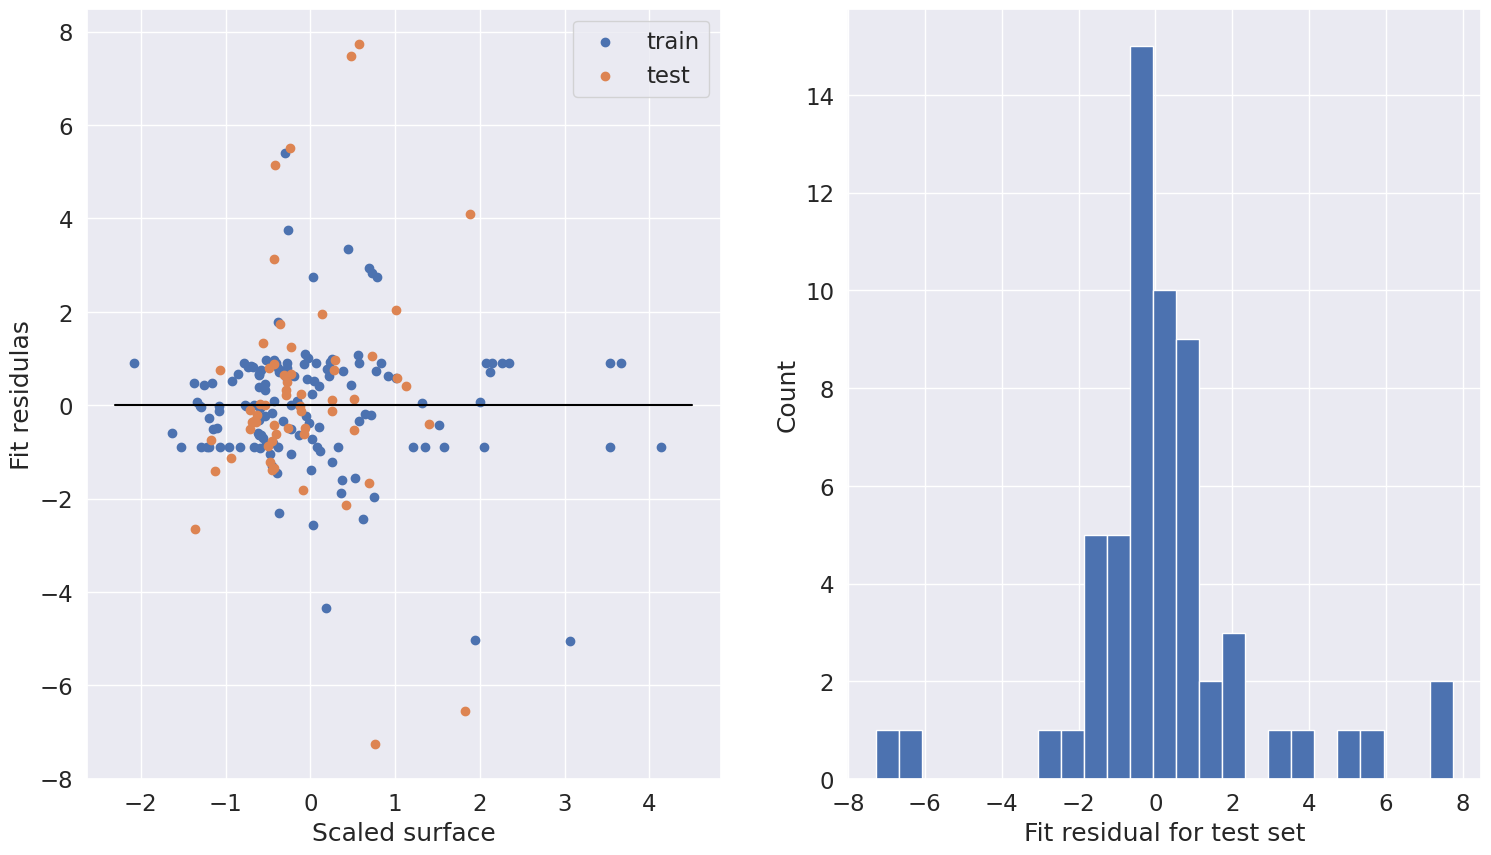

mean residuals: 0.23 
std: 2.41


In [ ]:
# plot the residuals
plotResidue(svr_cv, X, y, rs=rs)

## Comparing the estimators

In [ ]:
# fcuntions to make a comparision between all the models
def sortXy( X, y ):
    """
    Prepares the features to have the fit only for "surface" variable.
    """
    df = X.copy()
    df["price"] = y
    df = df.sort_values("surface").reset_index(drop=True)
    return df.drop(columns=["price"]), df["price"]

#######################################
def get_scores( X, y, est_name, est ):
    """
    Computes the validation and tets scores.
    Params:
        X: Pandas dataframe, feature data
        y: Pandas series, target
        est_name: str
            estromator name
        est: regressor
            the regression estimator
    Return:
        r2 for the test sample, mse for validation sample and the labels for plotting.
    """
    y_pred = est.predict(X)
    r2_test = round(r2_score(y, y_pred), 1)
    if est_name=="Linear Regression" :
        mse_cv = "--"
    elif est_name=="Extreme Gradient Boosting":
        mse_cv = round(df_grid_best["val_score"].to_list()[0],1)
    elif est_name=="K-Nearest Neighbors Regression":
        mse_cv = round(score_val_knn,1)
    else :
        mse_cv=round(abs(est.best_score_), 1)

    lbl = est_name+":  R2_test="+str(r2_test)+", MSE_cv="+str(mse_cv)

    return r2_test, mse_cv, lbl


#######################################
def plotLines( X, y, estimators, rs):
    """
    Plots the fitted curve for the given estimators to test data vs. "surface" variable.
    Params:
        X: Pandas dataframe
            features
        y: Pandas series
            target
        estimators: list
            list of regressors
        rs: int
            random state
    """
    X, y = sortXy( X, y )
    colors = ["k", "b", "r", "g"]
    fig, axe = plt.subplots(figsize=(20,10))
    axe.scatter( X["surface"], y )
    i = 0
    for k, estimator  in estimators.items():
        r2_test, mse_cv, label = get_scores( X, y, k, estimator )
        axe.plot(X["surface"], estimator.predict(X), label=label, c=colors[i])
        i+=1
    axe.set_xlabel("Scaled surface")
    axe.set_ylabel("Price in millions")
    axe.legend()



In [ ]:
estimators1 = {
              "Linear Regression": lr,
              "Ridge Regression": ridg_cv,
              "Lasso Regression": lasso_cv,
              "Elastic Net": elastic_cv,
}

estimators2 = {
              "Random Forest Regression": rfr_cv,
              "Extreme Gradient Boosting": xgbr,
              "K-Nearest Neighbors Regression": knn_cv,
              "Support Vector Regression": svr_cv
}



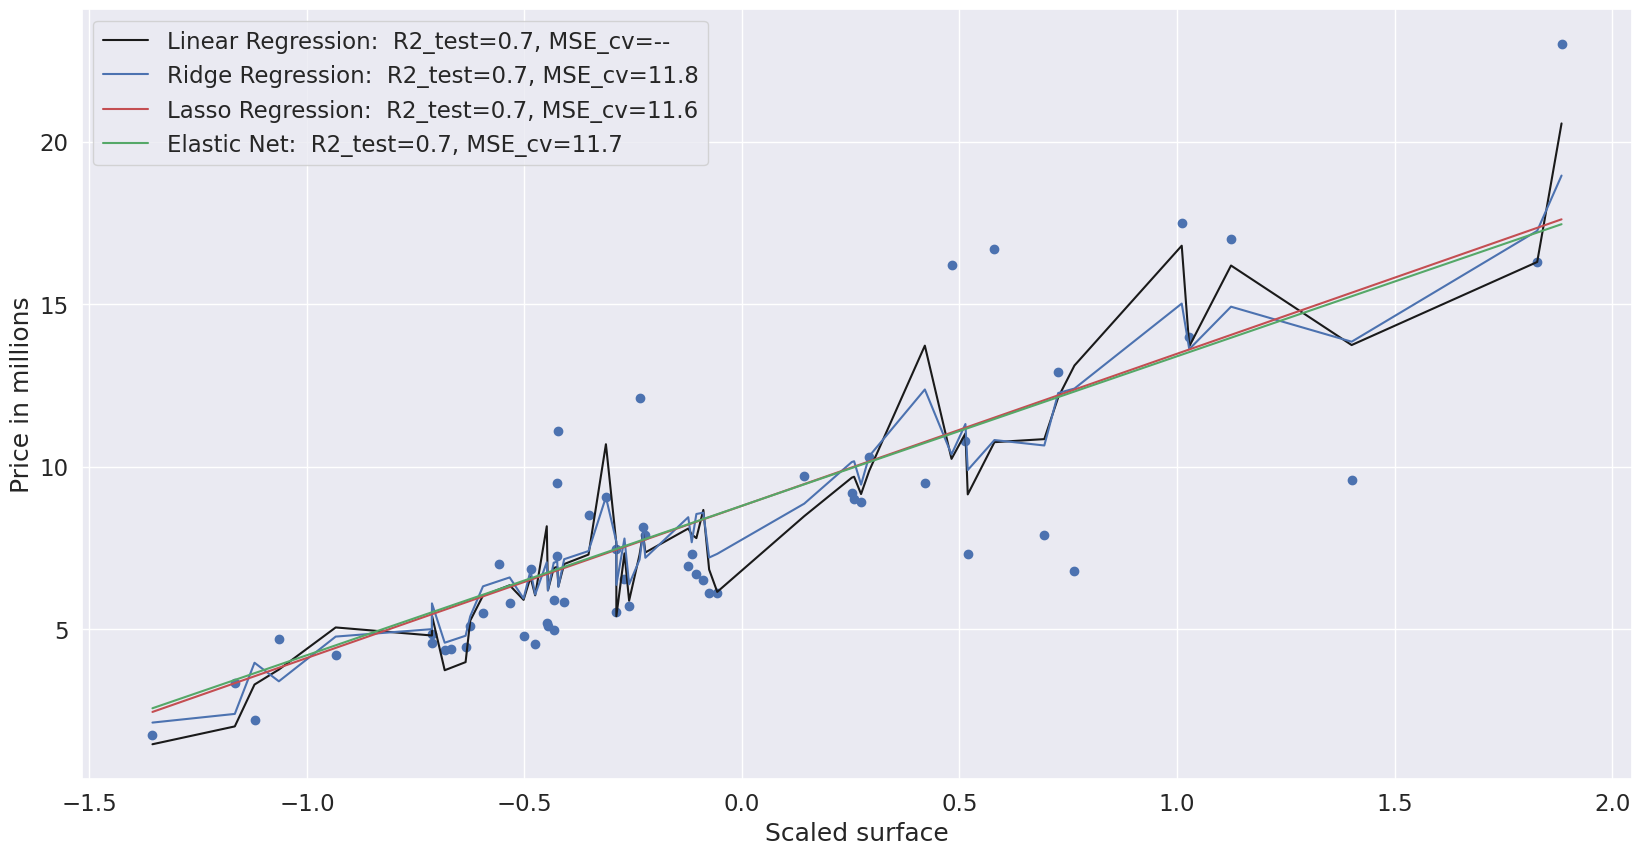

In [ ]:
plotLines(X_test ,y_test, estimators1, rs=rs)

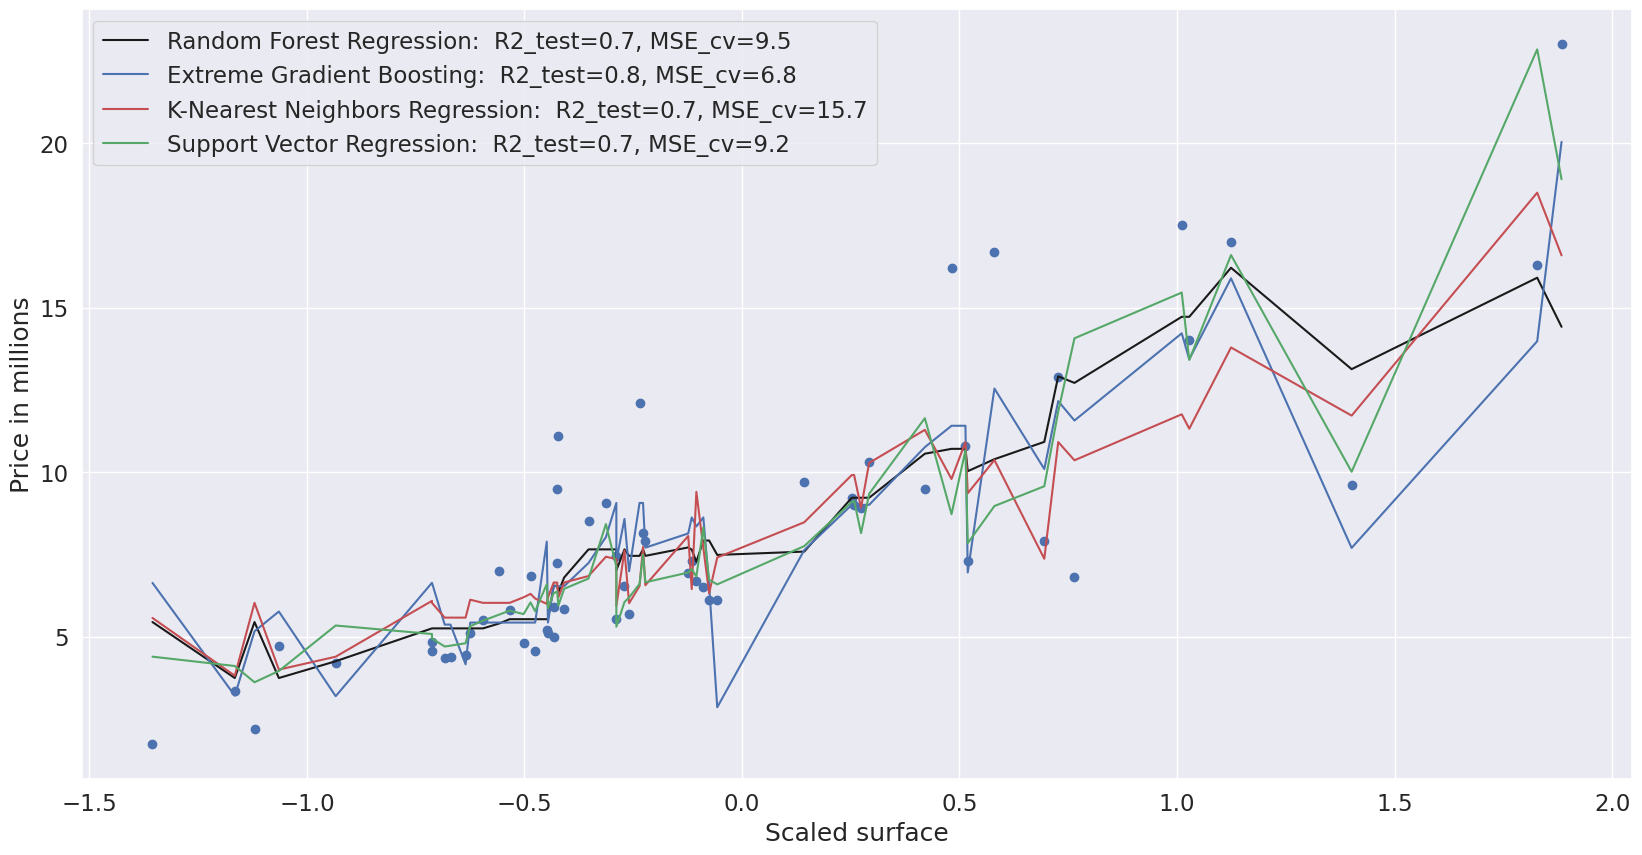

In [ ]:
plotLines(X_test,y_test, estimators2, rs=rs)

# Conclusion

We have conclude that our best estimator at first is the  -

Extreme Gradient boosting

followd by Support Vector Regressor and then the Linear regression methods